In [2]:
%pylab inline
import numpy as np
from tqdm import trange
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import torch

Populating the interactive namespace from numpy and matplotlib


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:]
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:]
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [11]:
X_train = X_train.reshape(-1, 1, 28, 28)
X_train = np.pad(X_train, ((0,0),(0,0),(2,2),(2,2)), 'constant')
X_test = X_test.reshape(-1, 1, 28, 28)
X_test = np.pad(X_test, ((0,0),(0,0),(2,2),(2,2)), 'constant')
print(X_train.shape, X_test.shape)

(60000, 1, 32, 32) (10000, 1, 32, 32)


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
#samp = np.random.randint(0, X_train.shape[0], size=(BS))
#test = torch.tensor(X_train[samp]).float()
#print(test.shape)
#print(model(test))

loss 0.04 accuracy 0.99: 100%|██████████| 1000/1000 [00:12<00:00, 79.06it/s]


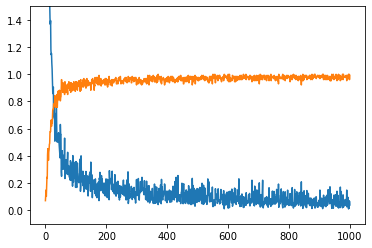

In [14]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()
BS = 128

losses, accuracies = [], []
for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp]).float()
    labels = torch.tensor(Y_train[samp]).long()
    
    optimizer.zero_grad()   # zero the gradient buffers
    outputs = model(X)
    cat = torch.argmax(outputs, dim=1)
    
    acc = (labels == cat).float().mean()
    loss = criterion(outputs, labels)
    loss = loss.mean()
    losses.append(loss.item())
    
    loss.backward()
    optimizer.step()
    
    accuracy = acc.item()
    accuracies.append(acc)
    t.set_description("loss %.2f accuracy %.2f" % (loss.item(), accuracy))
plt.ylim(-0.1, 1.5)
plot(losses)
plot(accuracies)

[4]
tensor(4)


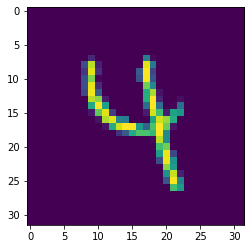

In [59]:
samp = np.random.randint(0, X_train.shape[0], size=(1))
test = torch.tensor(X_train[samp]).float()
print(Y_train[samp])
print(torch.argmax(model(test)))
plt.imshow(test.view(32,32))

In [93]:
y_hat = model(torch.tensor(X_test).float())
Y = torch.tensor(Y_test)

In [99]:
print(Y == torch.argmax(y_hat, dim=1).lmean())

RuntimeError: Can only calculate the mean of floating types. Got Long instead.